In [1]:
!pip install scikit-image==0.17.2
import numpy
from osgeo import gdal
import matplotlib.pyplot as plt
from skimage import measure


     |████████████████████████████████| 12.4MB 332kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


(42, 42)


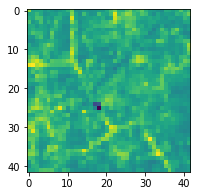

In [2]:
# input data
# don't forget to mount the drive from your left side menu (Files --> Mount drive icon)
ndvi = gdal.Open("/content/drive/My Drive/resampling/ndvi-first-test.tif")
ndvi = numpy.array(ndvi.GetRasterBand(1).ReadAsArray())
ndvi = ndvi[0:42,0:42] # crop to divisible by 3 for simplicity
plt.figure(figsize=(3,3))
plt.imshow(ndvi)
print(ndvi.shape)

In [3]:
# classification parameters
bin_edges = [0.0, 0.1, 0.2, 0.3, 1.0] # edges
classes = list(range(1,len(bin_edges))) # class names
print(bin_edges, classes)

[0.0, 0.1, 0.2, 0.3, 1.0] [1, 2, 3, 4]


In [4]:
def area_per_class(array,classes,scale):
  import numpy
  (unique, count) = numpy.unique(array, return_counts=True)
  #print(classes,unique,count)
  count = count if len(unique)==len(classes) else [numpy.insert(count,classes.index(i),0) for i in list(set(classes)-set(unique))][0]
  #print([numpy.insert(count,classes.index(i),0) for i in list(set(classes)-set(unique))])
  areas = count * scale**2
  return areas

shape:  (42, 42)
Area per class at native resolution [    900   97200 1395900   93600]
control checksum: 1587600


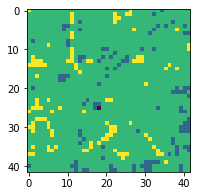

In [5]:
# classify native resolution, which will serve as control results
# Downsample
## Nothing to do, native resolution

# Classify
control = numpy.digitize(ndvi,bins=bin_edges)

# Stats
control_areas = area_per_class(control,classes,30)

# Display
plt.figure(figsize=(3,3))
plt.imshow(control, aspect='equal')
print('shape: ', control.shape)
print('Area per class at native resolution', control_areas)

# Sanity check
checksum = control_areas.sum()
print('control checksum:', checksum)

shape:  (42, 42)
Classes							 [1, 2, 3, 4]
Area per class for control dataset			 [    900   97200 1395900   93600]
Area per class for nearest neighbour downsampling	 [      0   89100 1377000  121500]
Error 							 [  -900  -8100 -18900  27900]
Error as percentage 					 [-100.           -8.33333333   -1.35396518   29.80769231]
checksum: 0


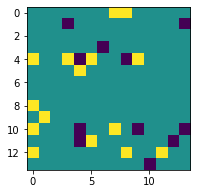

In [6]:
# nearest neighbour downsample and classify
# Downsample by nearest neighbour
ndvi_nearest_neighbour = ndvi[1::3,1::3].copy()

# Classify
nearest_neighbour = numpy.digitize(ndvi_nearest_neighbour,bins=bin_edges)

# Stats for nearest neighbour
nearest_neighbour_areas = area_per_class(nearest_neighbour,classes,90)

# Error
nearest_neighbour_error = numpy.subtract(nearest_neighbour_areas,control_areas)
nearest_neighbour_error_percentage = numpy.divide(nearest_neighbour_error,control_areas)

# Display
plt.figure(figsize=(3,3))
plt.imshow(nearest_neighbour, aspect='equal')
print('shape: ', control.shape)
print('Classes\t\t\t\t\t\t\t', classes)
print('Area per class for control dataset\t\t\t', control_areas)
print('Area per class for nearest neighbour downsampling\t', nearest_neighbour_areas)
print('Error \t\t\t\t\t\t\t', nearest_neighbour_error)
print('Error as percentage \t\t\t\t\t', nearest_neighbour_error_percentage*100)

# Sanity check
current_checksum = nearest_neighbour_areas.sum()
print('checksum:', checksum-current_checksum)

shape:  (42, 42)
Classes							 [1, 2, 3, 4]
Area per class for control dataset			 [    900   97200 1395900   93600]
Area per class for mean downsampling			 [      0   16200 1563300    8100]
Error 							 [  -900 -81000 167400 -85500]
Error as percentage 					 [-100.          -83.33333333   11.99226306  -91.34615385]
checksum: 0


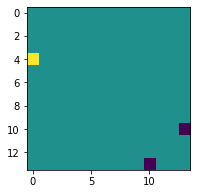

In [7]:
# Mean downsample and classify
# Downsample by mean
ndvi_mean = measure.block_reduce(ndvi,(3,3),numpy.mean)

# Classify
mean = numpy.digitize(ndvi_mean,bins=bin_edges)

# Stats
mean_areas = area_per_class(mean,classes,90)

# Error
mean_error = numpy.subtract(mean_areas,control_areas)
mean_error_percentage = numpy.divide(mean_error,control_areas)

# Display
plt.figure(figsize=(3,3))
plt.imshow(mean, aspect='equal')
print('shape: ', control.shape)
print('Classes\t\t\t\t\t\t\t', classes)
print('Area per class for control dataset\t\t\t', control_areas)
print('Area per class for mean downsampling\t\t\t', mean_areas)
print('Error \t\t\t\t\t\t\t', mean_error)
print('Error as percentage \t\t\t\t\t', mean_error_percentage*100)

# Sanity check
current_checksum = mean_areas.sum()
print('checksum:', checksum-current_checksum)

In [8]:
# Helper function for random downsampling
def random_pick(array, axis, numpy_histogram=None, seed=None):
	import numpy
	last_dimension_size = numpy.prod(numpy.array(array.shape)[numpy.array(axis)]) # and also the length of the flattened block
	array = numpy.moveaxis(array,axis,range(-len(axis),0)) # move the axis of interest to the end for easy navigation
	final_shape = array.shape[0:array.ndim-len(axis)] # save the shape of the 
	array = array.reshape(-1,last_dimension_size) # flatten to bidimensional array, so that the inner axis can be reduced
	random_generator = numpy.random.default_rng(seed) # it is important that the same random generator be used for the entire array
	if numpy_histogram is not None:
		numpy_histogram[1][-1] += numpy.finfo(numpy.float32).resolution # minimally expand last interval to include the maximum value
		array = numpy.apply_along_axis(histogram_weighted_choice,-1,array,numpy_histogram=numpy_histogram,random_generator=random_generator) # histogram based random choice
	else:
		array = numpy.apply_along_axis(random_generator.choice,-1,array) # pure random choice
	array = array.reshape(final_shape) # reshape to non-reduced axis
	return array

In [17]:
# Random downsample and classify
# Downsample by randomly choosing one value from the block
runs=1000000
random_error = numpy.zeros_like(control_areas)
print(random_error.dtype)
for seed in range(runs):
  ndvi_random = measure.block_reduce(ndvi,(3,3),random_pick,func_kwargs={'seed':seed})

  # Classify
  random = numpy.digitize(ndvi_random,bins=bin_edges)

  # Stats
  random_areas = area_per_class(random,classes,90)

  # Error
  random_error += numpy.subtract(random_areas,control_areas)
random_error = random_error/runs
random_error_percentage = numpy.divide(random_error,control_areas)

# Display
plt.figure(figsize=(3,3))
plt.imshow(random, aspect='equal')
print('shape: ', control.shape)
print('Classes\t\t\t\t\t\t\t', classes)
print('Area per class for control dataset\t\t\t', control_areas)
print('Area per class for random downsampling\t\t\t', random_areas)
print('Error \t\t\t\t\t\t\t', random_error)
print('Error as percentage \t\t\t\t\t', random_error_percentage*100)

# Sanity check
current_checksum = random_areas.sum()
print('checksum:', checksum-current_checksum)

int64


IndexError: ignored

In [11]:
# Helper function for weighted histogram
def histogram_weighted_choice(linear_block, random_generator, numpy_histogram=None):
	import numpy
	weights = None
	if numpy_histogram is not None:
		idx = numpy.digitize(linear_block,numpy_histogram[1]) # extract indices corresponding to values in the block
		idx = numpy.subtract(idx,1) # bins are 1-based
		weights = numpy_histogram[0][idx] # but we need these indices for the 0-based histogram
		weights = [float(weight)/sum(weights) for weight in weights] # which we need to normalize to use as probabilities
	return random_generator.choice(linear_block,p=weights)

[1, 2, 3, 4] [2 3 4] [  3 191   2]
shape:  (42, 42)
Classes							 [1, 2, 3, 4]
Area per class for control dataset			 [    900   97200 1395900   93600]
Area per class for histogram weighted downsampling			 [      0   24300 1547100   16200]
Error 							 [  -900 -72900 151200 -77400]
Error as percentage 					 [-100.          -75.           10.83172147  -82.69230769]
checksum: 0


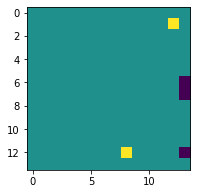

In [12]:
# Histogram weighted random downsample and classify
# Downsample by randomly choosing one value from the block weighted by the global histogram
ndvi_histogram = numpy.histogram(ndvi,density=True)
ndvi_histogram_random = measure.block_reduce(ndvi,(3,3),random_pick,func_kwargs={'seed':0,'numpy_histogram':ndvi_histogram})

# Classify
histogram_random = numpy.digitize(ndvi_histogram_random,bins=bin_edges)

# Stats
histogram_random_areas = area_per_class(histogram_random,classes,90)

# Error
histogram_random_error = numpy.subtract(histogram_random_areas,control_areas)
histogram_random_error_percentage = numpy.divide(histogram_random_error,control_areas)

# Display
plt.figure(figsize=(3,3))
plt.imshow(histogram_random, aspect='equal')
print('shape: ', control.shape)
print('Classes\t\t\t\t\t\t\t', classes)
print('Area per class for control dataset\t\t\t', control_areas)
print('Area per class for histogram weighted downsampling\t\t\t', histogram_random_areas)
print('Error \t\t\t\t\t\t\t', histogram_random_error)
print('Error as percentage \t\t\t\t\t', histogram_random_error_percentage*100)

# Sanity check
current_checksum = histogram_random_areas.sum()
print('checksum:', checksum-current_checksum)

In [13]:
# Helper function for calculating angles between area vectors
def unit_vector(vector):
  import numpy
  """ Returns the unit vector of the vector.  """
  return vector / numpy.linalg.norm(vector)

def angle_between(v1, v2):
  import numpy
  """ Returns the angle in radians between vectors 'v1' and 'v2'::
          >>> angle_between((1, 0, 0), (0, 1, 0))
          1.5707963267948966
          >>> angle_between((1, 0, 0), (1, 0, 0))
          0.0
          >>> angle_between((1, 0, 0), (-1, 0, 0))
          3.141592653589793
  """
  v1_u = unit_vector(v1)
  v2_u = unit_vector(v2)
  return numpy.arccos(numpy.clip(numpy.dot(v1_u, v2_u), -1.0, 1.0))

In [14]:
# Tie all results up
areas = {
    'control': control_areas,
    'mean': mean_areas,
    'nearest': nearest_neighbour_areas,
    'random': random_areas,
    'histogram': histogram_random_areas
}

total_error_area = dict(zip(areas.keys(),[numpy.sum(numpy.absolute(numpy.subtract(area,areas['control']))) for area in areas.values()]))
total_error_area_sorted = sorted( ((v,k) for k,v in total_error_area.items()), reverse=False)
angle_area = dict(zip(areas.keys(),[numpy.degrees(angle_between(area,areas['control'])) for area in areas.values()]))
angle_area_sorted = sorted( ((v,k) for k,v in angle_area.items()), reverse=False)
angle_area_sorted
magnitude_error_area = dict(zip(areas.keys(),[numpy.linalg.norm(numpy.subtract(area,areas['control'])) for area in areas.values()]))
magnitude_error_area_sorted = sorted( ((v,k) for k,v in magnitude_error_area.items()), reverse=False)
magnitude_error_area_sorted

#Display
print('Total wrong area:',total_error_area_sorted)
print('Angle area:',angle_area_sorted)
print('Magnitude area:',magnitude_error_area_sorted)

Total wrong area: [(0, 'control'), (55800, 'nearest'), (75600, 'random'), (302400, 'histogram'), (334800, 'mean')]
Angle area: [(8.537736462515939e-07, 'control'), (1.2263510341925212, 'random'), (1.2377642190495652, 'nearest'), (4.461563308169474, 'histogram'), (4.892117047536994, 'mean')]
Magnitude area: [(0.0, 'control'), (34670.4485116648, 'nearest'), (46678.688927603784, 'random'), (184844.3128689655, 'histogram'), (204682.2415355079, 'mean')]


drive  sample_data
